In [1]:
import numpy as np
import xarray as xr
import rioxarray as rxr
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix
import sys
sys.path.append('D:/COPY/Projekt_FF/Scripts/src/')

In [2]:
# Load preprocessed dataset (DOP (training area) with forest_mask)
filepath = 'D:/COPY/Projekt_FF/Process/dop_train_forestmask.nc'
dop_train = rxr.open_rasterio(filepath)
dop_train = dop_train.squeeze()
dop_train

<xarray.Dataset>
Dimensions:              (x: 10000, y: 10000)
Coordinates:
    band                 int32 1
  * x                    (x) float64 4.68e+05 4.68e+05 ... 4.69e+05 4.69e+05
  * y                    (y) float64 5.672e+06 5.672e+06 ... 5.671e+06 5.671e+06
    transverse_mercator  int32 0
    spatial_ref          int32 0
Data variables:
    Band1                (y, x) uint8 ...
    Band2                (y, x) uint8 ...
    Band3                (y, x) uint8 ...
    Band4                (y, x) uint8 ...
    forest_mask          (y, x) uint8 ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.5.3, released 2022/10/21
    history:      Fri Nov 11 15:58:37 2022: GDAL CreateCopy( D:/COPY/Projekt_...

### **U-Net approach**
Define the model using a pretrained model (MobileNetV2). The following steps are based on the [TensorFlow tutorial on image segmentation](https://www.tensorflow.org/tutorials/images/segmentation).

In [3]:
# Define tile size
tilesize = 224

In [4]:
# Load pretrained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=[tilesize, tilesize, 3], include_top=False)

# Overview of the model architecture
# Switch 'button' to True for printing
button = False

if button == True:
    print(base_model.summary())
else:
    pass

In [5]:
# Modify the model
# First the downstack/downsampler

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

# Make this part of the model fix (not trainable)
down_stack.trainable = False

In [6]:
# Upstack/Upsampler
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [7]:
# Define modified U-Net
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[tilesize, tilesize, 3])
    x = inputs
    
    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [8]:
# Compile the model with 2 output channels/classes
OUTPUT_CHANNELS = 2

model = unet_model(output_channels=OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
# Plot the resulting model architecture
# Switch 'button' to True for printing
button = False

if button == True:
    tf.keras.utils.plot_model(model, show_shapes=True)
else:
    pass

In [9]:
# Split DOP into tiles
# Create an instance of the data generator
# Hand over the training data (DOP with forest_mask)
from datagen import CustomImageDataGenerator

cidg_training   = CustomImageDataGenerator(dop_train, tilesize=tilesize, sampletype='training')
cidg_validation = CustomImageDataGenerator(dop_train, tilesize=tilesize, sampletype='validation')

In [10]:
# Function to display exemplary data
def plotExample(dataGen, batch_id, tile_id):
    batch = dataGen.__getitem__(batch_id)
    predi = model.predict(batch[0])
    
    fig, ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(batch[0][tile_id]); ax[0].set_title('RGB input')
    ax[1].imshow(batch[1][tile_id], cmap='Greys', interpolation='None'); ax[1].set_title('True mask')
    ax[2].imshow(np.argmax(predi[tile_id], axis=-1), cmap='Greys', interpolation='None'); ax[2].set_title('Prediction')
    plt.show()
    
    return

5/5 [==============================] - 7s 1s/step


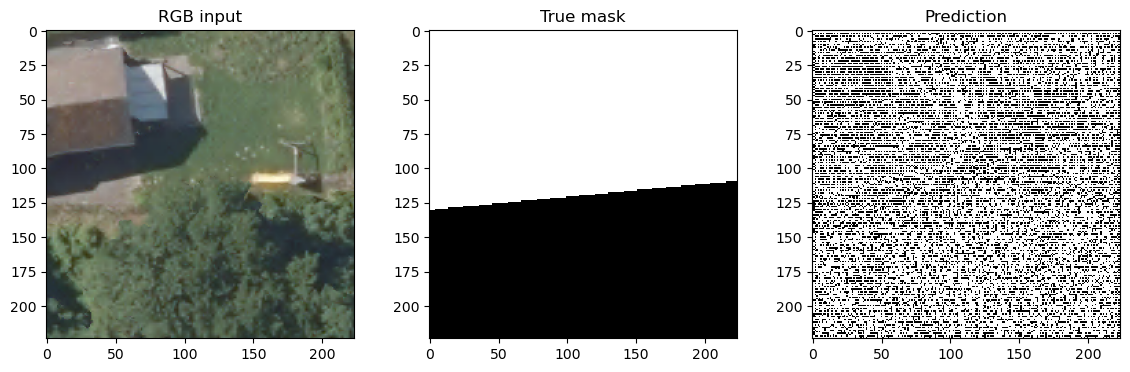

1/1 [==============================] - 0s 242ms/step


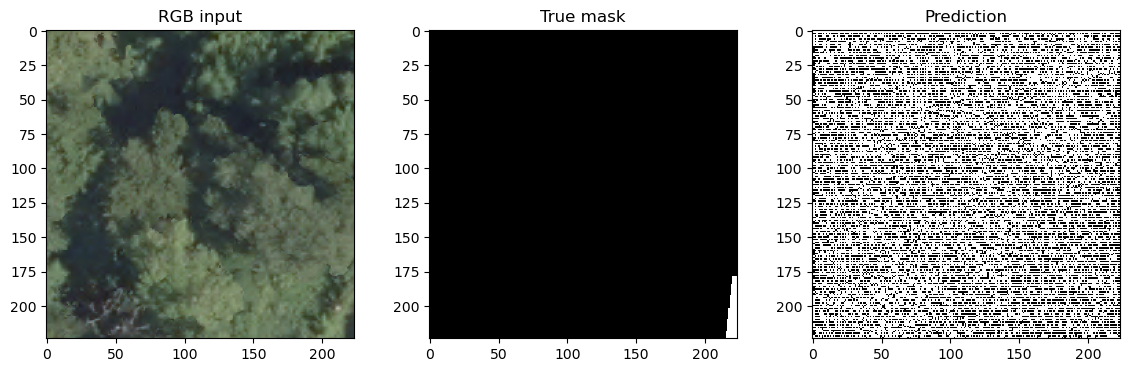

In [11]:
plotExample(cidg_training, 10, 17)
plotExample(cidg_validation, 10, 3)

### Model training

In [12]:
model_history = model.fit(cidg_training,
                          validation_data=cidg_validation,
                          epochs=20,
                          initial_epoch=0)

Epoch 1/20
44/44 [==============================] - 578s 13s/step - loss: 0.7214 - accuracy: 0.6431 - val_loss: 0.5991 - val_accuracy: 0.8366
Epoch 2/20
44/44 [==============================] - 605s 14s/step - loss: 0.5364 - accuracy: 0.7471 - val_loss: 0.4284 - val_accuracy: 0.8687
Epoch 3/20
44/44 [==============================] - 591s 13s/step - loss: 0.5099 - accuracy: 0.7665 - val_loss: 0.6189 - val_accuracy: 0.8193
Epoch 4/20
44/44 [==============================] - 575s 13s/step - loss: 0.4741 - accuracy: 0.7922 - val_loss: 0.3680 - val_accuracy: 0.8716
Epoch 5/20
44/44 [==============================] - 571s 13s/step - loss: 0.4406 - accuracy: 0.8165 - val_loss: 0.5071 - val_accuracy: 0.8254
Epoch 6/20
44/44 [==============================] - 571s 13s/step - loss: 0.4498 - accuracy: 0.8043 - val_loss: 0.4543 - val_accuracy: 0.7767
Epoch 7/20
44/44 [==============================] - 578s 13s/step - loss: 0.4333 - accuracy: 0.8193 - val_loss: 0.3465 - val_accuracy: 0.8586
Epoch 

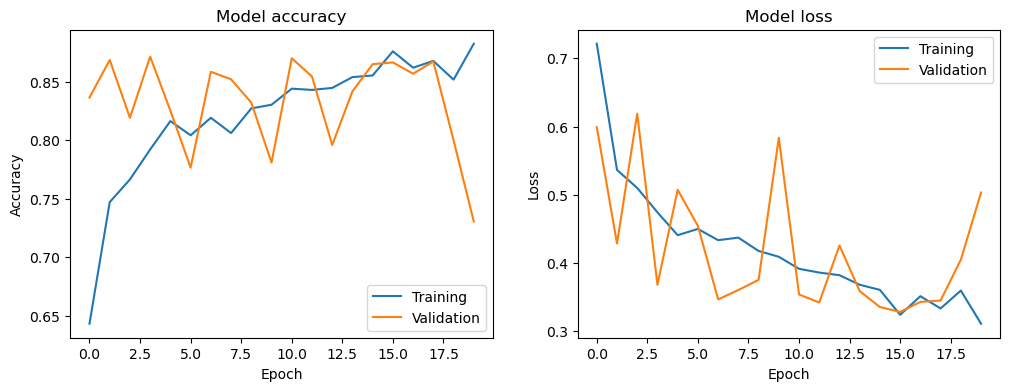

In [13]:
# Plot accuracy and loss over the epochs
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(model_history.history['accuracy'])
ax[0].plot(model_history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training', 'Validation'], loc='lower right')

ax[1].plot(model_history.history['loss'])
ax[1].plot(model_history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training', 'Validation'], loc='upper right')

plt.show()

### Example predictions

5/5 [==============================] - 6s 1s/step


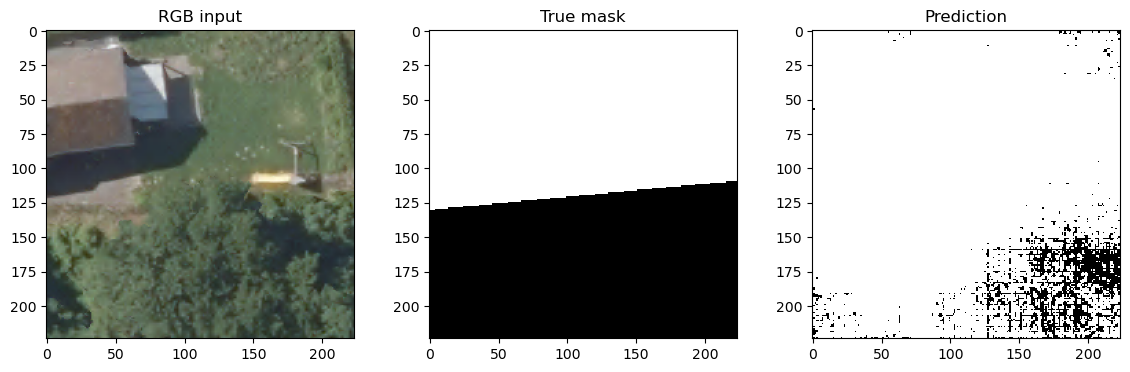

1/1 [==============================] - 0s 232ms/step


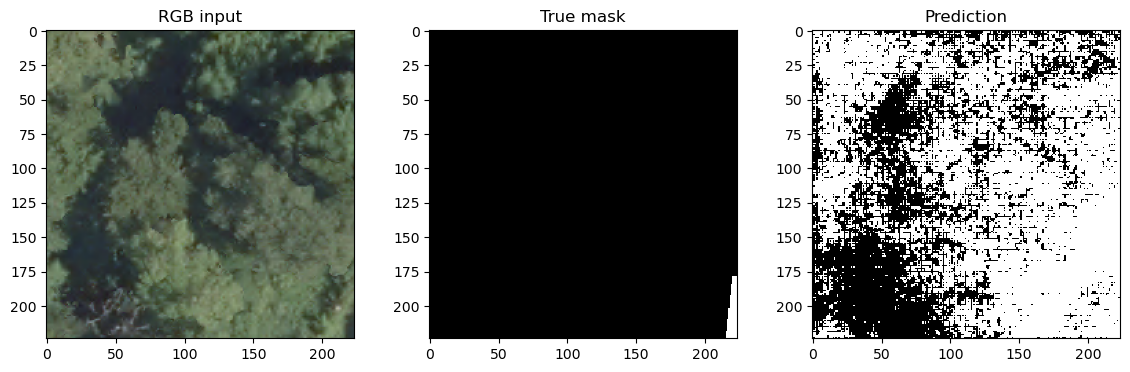

In [14]:
plotExample(cidg_training, 10, 17)
plotExample(cidg_validation, 10, 3)

In [ ]:
# Save trainend model
model.save('D:/COPY/Projekt_FF/Process//UNet_forest_with_augmentation')